## Background
Previously, I modeled a "heat box", but ignored the effects of the sun. As anyone who has had to get into a car that has sat outside for a while on a hot summer day, the inside of the car is warmer than the outside air temperature, and my previous model didn't allow that. So the sun is important.  Consider the following information from [The Humane Society](https://www.humanesociety.org/resources/what-do-if-you-see-pet-parked-car).

> It doesn't have to be that warm outside for a car to become dangerously hot inside.
>
> - When it's 72 degrees Fahrenheit outside, the temperature inside your car can heat up to 116 degrees Fahrenheit within an hour.
> - When it's 80 degrees Fahrenheit outside, the temperature inside your car can heat up to 99 degrees Fahrenheit within 10 minutes.
> - Rolling down the windows has been shown to have little effect on the temperature inside a car.

Let's translate these temperatures to Celsius and Kelvin

- When it's 22 degrees Celsius (295 K) outside, the temperature inside your car can heat up to 47 degrees Celsius (320 K) within an hour.
- When it's 27 degrees Celsius (300 K) outside, the temperature inside your car can heat up to 37 degrees Celsius (310 K) within 10 minutes.

My plan for this post is to assume that my heat box will heat up similarly to the above generic car, and see what sort of parameters I need to make that work.

## Previous work
As before, I'll model the system as a simple box, utilizing the same thermal properties for the material.  

In [1]:
# Heat parameters
thermalDiffusivity = 22.39e-6 # meters^2/s for air
heatTransferCoef = 1 # For a typical metal to air
thermalConductivity = 50 # For a typical metal
specificHeat = 1000 # 890 for aluminum
wallDensity = 3000 # kg/m^3 for aluminum

## Convection Boundary Condition with heat generation
We can think of the sun as a big heater. Let's define $Q$ to be the energy flux from the sun.

$$
k \left. \frac{\partial u}{\partial n}\right|_{S} =  h \left(T_{\text{air}} - u(S,t)\right) + Q
$$

where $S$ describes the boundary surface, $h$ is the heat transfer coefficient. Since we will be applying the boundary condition at each time step, we can assume that

$$ 
Q = I_{\text{sun}} \Delta t
$$

In general, the intensity due to the sun will depend on many things, like how cloudy it is, as well as the angle that direct sunlight makes with the surface. As a value to get started, I will estimate that the max solar intensity is 1000 W/m^2, a value that I found from the [Woods Hole Oceanographic Institution](https://www.whoi.edu/science/AOPE/mvco/description/SolRad.html). 

In general, Q will depend on the location on the surface as well as the time of day, so $Q(x,y,z,t)$, and I'll denote this as $Q^l_{ijk}$ when I apply the finite difference method.

In [2]:
# Solar energy flux
sunIntensity = 1000 # W/m^2 at the surface of the earth

airTemp = 22
groundTemp = airTemp
hotCarTemp = 47

wallThickness = 0.02 # 2 cm in meters

## Test 1: Hot car for 1 hour

Let's create a simulation to test the statement, "When it's 22 degrees Celsius (295 K) outside, the temperature inside your car can heat up to 47 degrees Celsius (320 K) within an hour."

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Length and time parameters (meters)
L = 3
W = 2
H = 2
T = 3600 # 1 hour in seconds

# Computational parameters (time step and mesh size)
Deltat = 20 # seconds
Deltax = 0.05  # 5 cm in meters
Qmax = sunIntensity * Deltat

xmax = int(L/Deltax)
ymax = int(W/Deltax)
zmax = int(H/Deltax)
tmax = int(T/Deltat)

xmid = xmax // 2
ymid = ymax // 2
zmid = zmax // 2

t = np.linspace(0,T,tmax)
xgrid = np.linspace(0,L,xmax+1)
ygrid = np.linspace(0,W,ymax+1)
zgrid = np.linspace(0,H,zmax+1)

## Getting numerical

Applying the finite difference method (as before), we can determine the boundary temperature in terms of the air temperature, effective solar temperature, and the temperature just inside the boundary:

$$
u^l_{Ijk} - u^l_{I-1 jk} = \frac{h\Delta x}{k} \left[T_{\text{air}} - u^l_{Ijk}\right] + \frac{\Delta x}{k} Q^l_{Ijk}
$$

Let's define the constant $\beta=\frac{h\Delta x}{k}$ (as was done in the previous post) so the above simplifies to:
$$
u^l_{Ijk} = \frac{u^l_{I-1 jk} + \beta T_{\text{air}} + \frac{\Delta x}{k} Q^l_{Ijk}}{1 + \beta}
$$


In [4]:
# Calculated params
beta = heatTransferCoef*Deltax/thermalConductivity

# Initialize the array(s) with a uniform initial temperature.
u = np.empty((tmax,xmax,ymax,zmax))
u_init = airTemp
u.fill(u_init)

def applyBC(umat, tl):
    t = tl*Deltat
    # x = 0, x=L boundaries
    umat[tl, 0, :, :] = (umat[tl, 1, :, :] + beta * airTemp)/(1+beta)
    umat[tl, xmax-1, :, :] = (umat[tl, xmax-2, :, :] + beta * airTemp)/(1+beta)
    # y = 0, y=L boundaries
    umat[tl, :, 0, :] = (umat[tl, :, 1, :] + beta * airTemp)/(1+beta)
    umat[tl, :, ymax-1, :] = (umat[tl, :, ymax-2, :] + beta * airTemp)/(1+beta)
    # z = 0, z=L boundaries
    umat[tl, :, :, 0] = (umat[tl, :, :, 1] + beta * airTemp)/(1+beta)
    umat[tl, :, :, zmax-1] = (umat[tl, :, :, zmax-2] + beta * airTemp)/(1+beta)
    return umat[tl,:,:,:]

In [5]:
def plotheatmaps(umat,l,i,j,k):
  Tmin = umat[l,:,:,:].min()
  Tmax = umat[l,:,:,:].max()
  
  xSlice = umat[l,i,:,:].transpose()
  ySlice = umat[l,:,j,:].transpose()
  zSlice = umat[l,:,:,k].transpose()
  
  time = Deltat*l
  tMins = time // 60
  theMinutes = tMins % 60
  
  tHours = tMins // 60
  theDays = tHours // 24
  theHours = tHours % 24
  
  theTime = str(theDays) + " days " + str(theHours) + " hrs "  + str(theMinutes) + " min"

  xC, yC, zC = [Deltax*i, Deltax*j, Deltax*k]
  
  fig, (ax0,ax1,ax2) = plt.subplots(ncols=3,width_ratios=[ymax,xmax,xmax],
              figsize=(8,3))
    
  fig.suptitle(f"Heatbox Temp at {theTime} \n Outdoor Temp = {airTemp:.0f} C \n Ground Temp = {groundTemp:.0f} C")
    
  im0 = ax0.pcolormesh(ygrid, zgrid, xSlice, shading="flat", vmin = Tmin, vmax = Tmax)
  ax0.set_aspect(1)
  ax0.set_title(f"x = {xC:.3f} m")
  ax0.set_xlabel("y")
  ax0.set_ylabel("z")

  im1 = ax1.pcolormesh(xgrid, zgrid, ySlice, shading="flat", vmin = Tmin, vmax = Tmax)
  ax1.set_aspect(1)
  ax1.set_title(f"y = {yC:.3f} m")
  ax1.set_xlabel("x")
  ax1.set_ylabel("z")
  
  im2 = ax2.pcolormesh(xgrid, ygrid, zSlice, shading="flat", vmin = Tmin, vmax = Tmax)
  ax2.set_aspect(1)
  ax2.set_title(f"z = {zC:.3f} m")
  ax2.set_xlabel("x")
  ax2.set_ylabel("y")
  
  fig.tight_layout()
  
  cax = fig.add_axes([ax0.get_position().x0,ax0.get_position().y0-0.2,
                ax2.get_position().x1 - ax0.get_position().x0, 0.02])
  fig.colorbar(im2, cax = cax, orientation='horizontal', label='Temperature (C)')


## Heat equation time evolution
As before, we can code in the heat equation and allow the system to evolve in time.

In [6]:
gamma = thermalDiffusivity*Deltat/Deltax**2

def solarHeating(umat, tl):
    t = tl*Deltat
    # z=H boundary gets heated (no corners/edges)
    umat[tl, 1:-1, 1:-1, zmax-1] = umat[tl-1, 1:-1, 1:-1, zmax-1] + sunIntensity /(specificHeat*wallDensity*wallThickness) + 
        gamma * (umat[l,2:,1:-1,zmax-1] + umat[l,:-2,1:-1,zmax-1] + umat[l,1:-1,2:,zmax-1] + umat[l,1:-1,:-2,zmax-1] + 
                                 umat[l,1:-1,1:-1,zmax-1] + umat[l,1:-1,1:-1,zmax-1] - 6 * umat[l,1:-1,1:-1,zmax-1]
    # z=H, x=0 boundary gets heated (edges only)  
    umat[tl, 0, 1:-1, zmax-1] = umat[tl-1, 0, 1:-1, zmax-1] + sunIntensity /(specificHeat*wallDensity*wallThickness) + 
    return umat[tl,:,:,:]
    
def calcHeatEqn(umat):
    tm, xm, ym, zm = umat.shape
    for l in range(0,tm-2):
        for i in range(1, xm-1):
            for j in range(1, ym-1):
                for k in range(1, zm-1):
                    umat[l+1,i,j,k] = umat[l,i,j,k] + gamma * (umat[l,i+1,j,k] + umat[l,i-1,j,k] + umat[l,i,j+1,k] + umat[l,i,j-1,k] + 
                                 umat[l,i,j,k+1] + umat[l,i,j,k-1] - 6 * umat[l,i,j,k])
        umat[l+1, :, :, :] = applyBC(umat, l+1)
        #if ((l+1)%10 == 0):
            #print(f"Step {l+1} out of {tm}")
    return umat

In [7]:
u = calcHeatEqn(u)

Say some things about heatmaps.

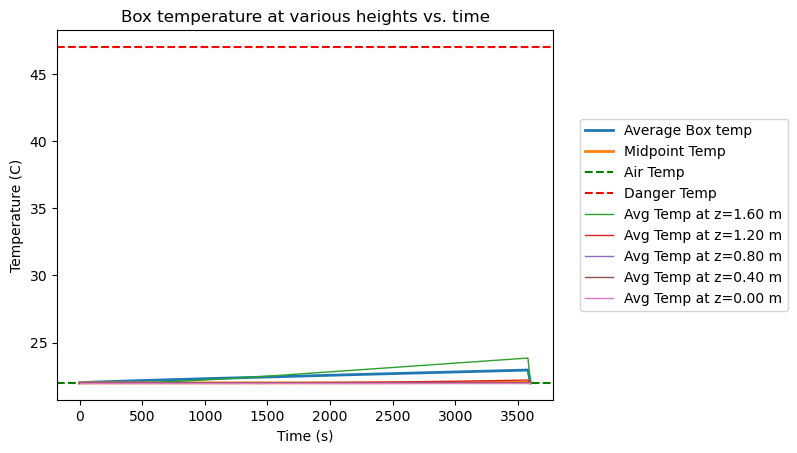

In [8]:
boxTemp = np.zeros(tmax)
boxTempMid = u[:,xmid,ymid,zmid]
boxTempZ = np.zeros((tmax,zmax))

for l in range(tmax):
  ul = u[l, :, :, :]
  boxTemp[l] = np.mean(ul)

  for k in range(zmax-3):
    ulk = ul[:,:,k]
    boxTempZ[l,k] = np.mean(ulk)


plt.plot(t, boxTemp, label='Average Box temp',linewidth=2)
plt.plot(t, boxTempMid, label='Midpoint Temp',linewidth=2)
plt.title("Box temperature at various heights vs. time")
plt.axhline(y=airTemp,label='Air Temp',ls='--',color='green')
plt.axhline(y=hotCarTemp,label='Danger Temp',ls='--',color='red')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
for k in reversed(range(0,zmax,zmax//5)):
    zval = k*Deltax
    labString = f"Avg Temp at z={zval:.2f} m"
    plt.plot(t,boxTempZ[:,k],label=labString, linewidth=1)

plt.legend(loc="center left", bbox_to_anchor=(1.04,0.5))
plt.show()

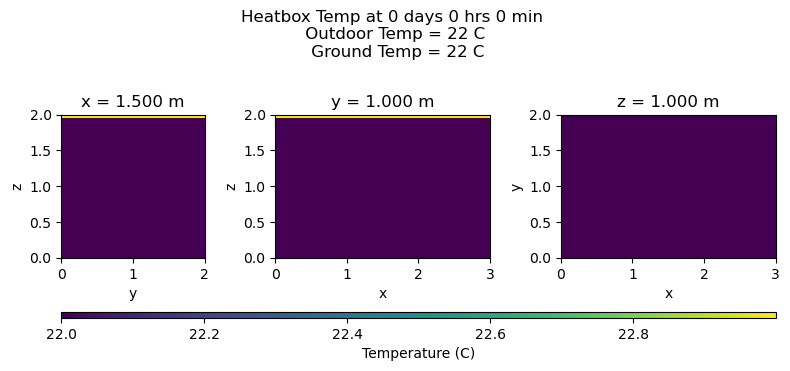

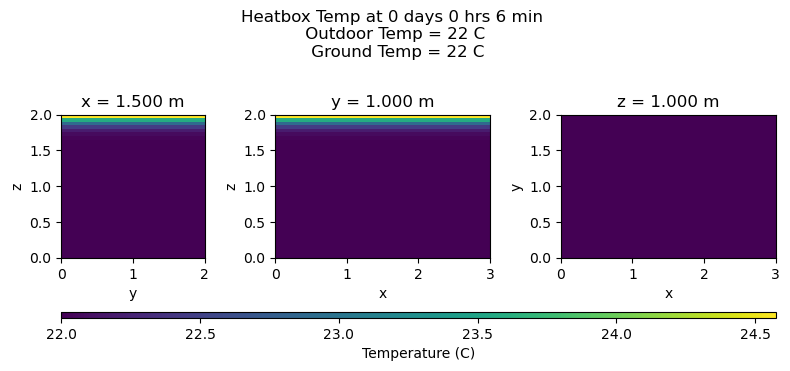

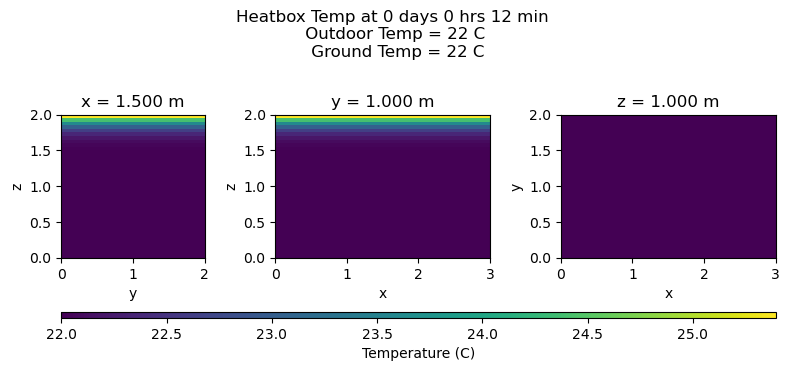

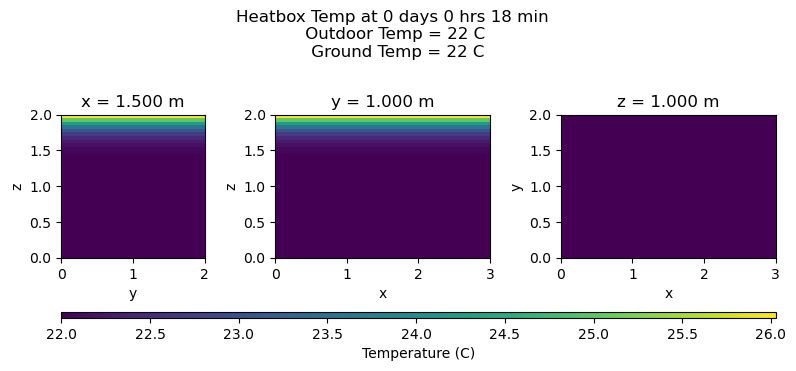

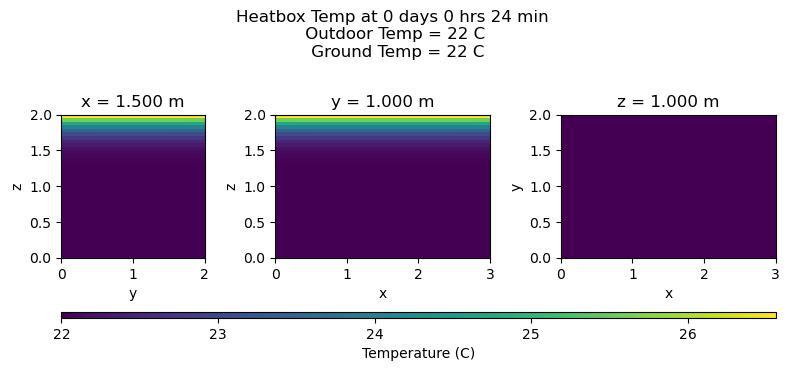

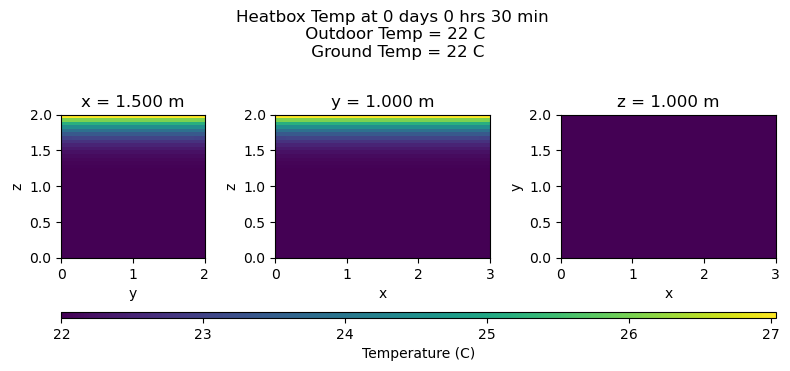

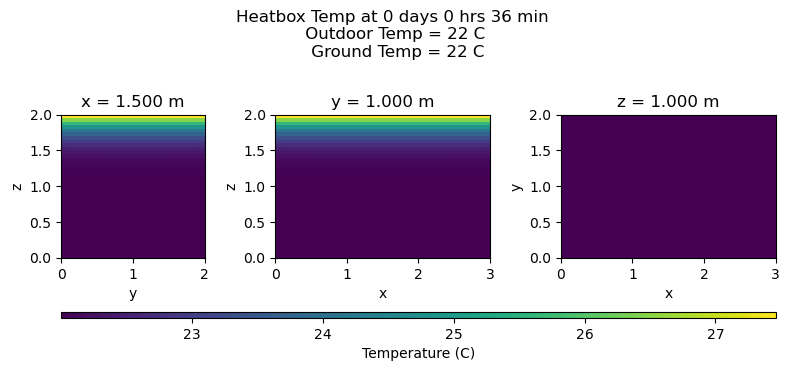

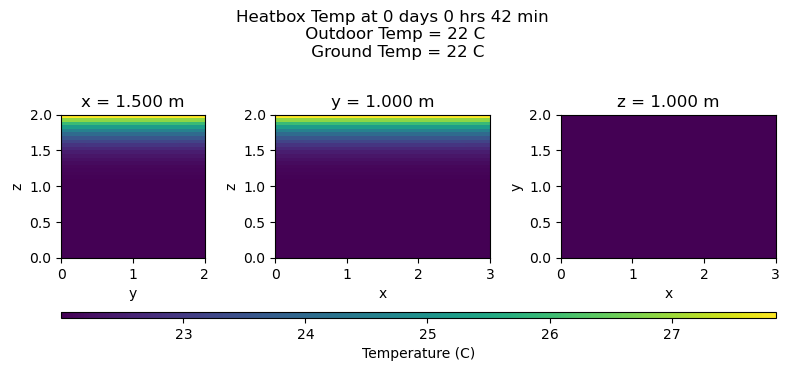

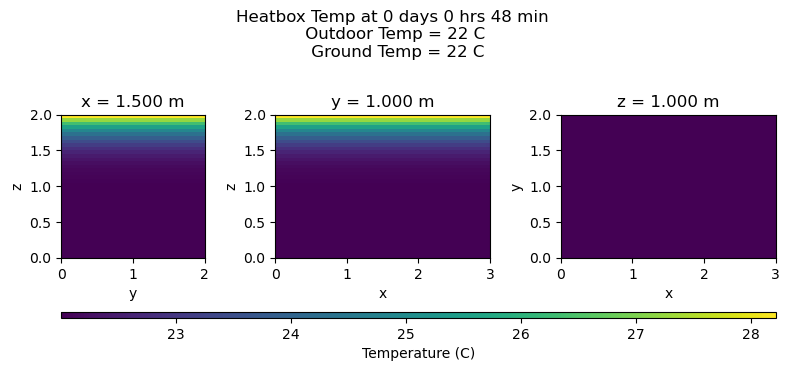

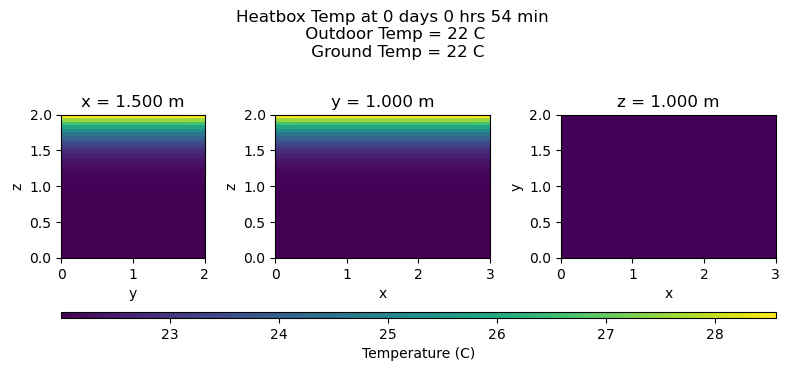

In [14]:
for l in range(1,tmax-1,tmax//10):
    plotheatmaps(u,l,xmid,ymid,zmid)

In [13]:
tmax

180

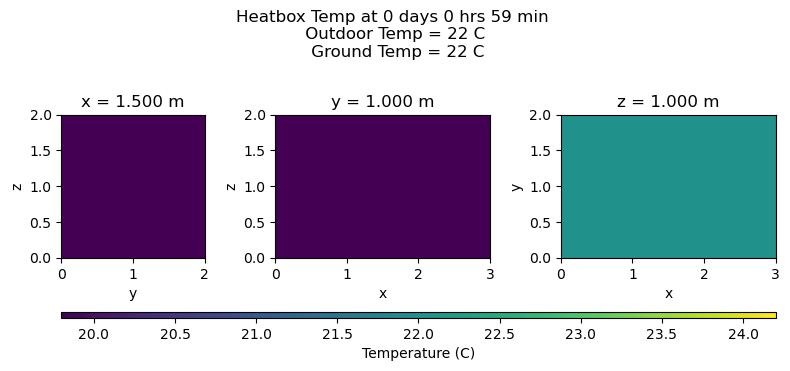

In [15]:
plotheatmaps(u,tmax-1,xmid,ymid,zmid)

This makes no sense